In [3]:
#import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)
%matplotlib inline

import utilities as util

#ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#hyperparameter optimization
#import itertools
#from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
#select smooth window size
window = 8

#read data and parameters for transformation
df, m, b, ref = util.read_data(csv_file = 'datahub/wti-daily_csv.csv', 
                              window = window)

df.set_index('Date',inplace=True)
df.head()

Time range: from 1986-01-02 00:00:00 to 2019-09-23 00:00:00


,Price,y,y_smooth_w8
Date,,,
1986-01-02,25.56,0.612381,0.608235
1986-01-03,26.00,0.629227,0.625871
1986-01-06,26.53,0.649185,0.636625
1986-01-07,25.85,0.622999,0.640946
1986-01-08,25.87,0.623551,0.639284


In [12]:
#################
### Functions ###
#################

def fit_arima(params,X,Y,target,n_inputs,n_outputs,df_coeff,exog_x=None,exog_y=None,add_exog=0):

    if add_exog == 1:
        col = exog_x.name
        exog_x = np.array(exog_x.reset_index()[col]).reshape(-1,1)
        exog_y = np.array(exog_y.reset_index()[col]).reshape(-1,1)

    #read parameters
    p,d,q = params
    #define model
    m = SARIMAX(X.reset_index()[target], exog = exog_x, 
                order=(p,d,q), seasonal_order=(0, 0, 0, 0))
        
    #fit the model
    m = m.fit(maxiter=300,disp=False)
    
    df_coeff = df_coeff.append(pd.DataFrame(m.params).T,ignore_index=True)
        
    #predict with 95% confidence interval
    pred = m.get_prediction(exog = exog_y, start = d, 
                            end = n_inputs + n_outputs - 1, 
                            dynamic=False,alpha = .05)
            
    y_pred = pred.predicted_mean
    #set original datetime index
    y_pred.index = X.index.union(Y.index)[d:]
    y_pred_cf = pred.conf_int()
    #set original datetime index
    y_pred_cf.index = y_pred.index
    
    return y_pred, y_pred_cf, d, df_coeff
    
def cv_plot(X_true, Y_true, y_pred, y_pred_cf, model_name, folder, img_num, slice_num = 0):
    #plot and save predictions:
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    #train data
    X_true.plot(marker='o',linewidth=0,markersize=3,color='k',label='train',ax = ax)
    #test data
    Y_true.plot(marker='o',linewidth=0,markersize=3,color='g',label='test',ax = ax)
    #predicted values
    y_pred.plot(linewidth=2.0,color='r',label='prediction')   
    #confidence intervals
    ax.fill_between(y_pred_cf.index,
                    y_pred_cf.iloc[:, 0],
                    y_pred_cf.iloc[:, 1], 
                    color='k', alpha=.2, label = '95% confidence')
    
    fs = 14
    ax.set_ylabel('Transformed price',fontsize=fs)
    ax.set_xlabel('Date',fontsize=fs)    
    ax.legend(loc='upper left',fontsize=fs)
    ax.set_title(f"Crude oil price prediction using {model_name}.",fontsize=fs)
    ax.set_ylim(-1,1.1)
    plt.savefig(f"{folder}/results/prediction_{img_num}.png")  
    
    #show only first plot
    if slice_num == 1:
        plt.show()
    else:
        plt.close(fig)
    
def cv_arima(df, cv_num, n_inputs, n_outputs, folder, 
             target, params = (4,1,1), model_name = 'ARIMA',
             add_exog = 0, exog_col='y'):
    """This function does cv_num CV
    for fitted ARIMA model
    exogeneour variable can be introduces"""

    #define path to store results
    path_res = f'/{target}_train_{n_inputs}_test_{n_outputs}_cv_{cv_num}'
    
    if add_exog != 0:
        path_res += f'{exog_col}'

    #make folders
    util.mkfolder(folder)
    folder += path_res
    util.mkfolder(folder)
    util.mkfolder(folder + '/results/')
    print(folder)
    
    #generate slices of data for CV
    #for a given target, e.g. smooth version
    x_sm, y_sm = util.sliding_windows(df[target], 
                       n_inputs = n_inputs, 
                       n_outputs = n_outputs) 
    #for true values
    x_true, y_true = util.sliding_windows(df['y'], 
                       n_inputs = n_inputs, 
                       n_outputs = n_outputs) 
    
    #calculate lagged exogenous variable
    x_ex, y_ex = util.sliding_windows(df[exog_col], shift = n_outputs,
                                          n_inputs = n_inputs, 
                                          n_outputs = n_outputs)  
    
    #define metric df
    df_metrics = pd.DataFrame()
    df_coeff = pd.DataFrame()
    df_true_pred = pd.DataFrame()
    
    print(f'Use {n_inputs} points to predict {n_outputs}.')
    
    #select last cv_num slices to perform cv test
    _ind = len(x_true)-cv_num
    #number of a slice to name an image
    img = _ind
    
    for X, Y, X_true, Y_true, exog_x, exog_y in zip(x_sm[_ind:],y_sm[_ind:],
                                                    x_true[_ind:],y_true[_ind:],
                                                    x_ex[_ind:], y_ex[_ind:]):
        
        if add_exog != 1:
            exog_x = None
            exog_y = None
        
        #fit the model and predict
        y_pred, y_pred_cf, d, df_coeff = fit_arima(params,X,Y,target,n_inputs,n_outputs,
                                                   df_coeff,exog_x,exog_y,add_exog)
        
        #calculate the metric with respect to true values in transformed units
        df_metrics = df_metrics.append(util.metric_df(Y_true, y_pred[n_inputs-d:]),
                                     ignore_index=True)
        
        #save Y_true and y_pred in transformed units
        df_true_pred = df_true_pred.append(pd.concat([Y_true, y_pred[n_inputs-d:]],axis=1))
                
        #slice completed, show every 10th
        slice_num = img - _ind + 1
        if slice_num % 10 == 0:
            print(f'Done with slice number {slice_num} out of {cv_num}.')
        img += 1  
        
        #plot train-test intervals
        cv_plot(X_true, Y_true, y_pred, y_pred_cf, model_name, folder, img, slice_num)


    #save dfs with arima coefficients
    df_coeff.index = np.arange(len(df_coeff))
    df_coeff.to_csv(f'{folder}/coeff.csv',index=False)
    
    #save parameters versus time slice
    fig = df_coeff.plot()
    plt.ylabel('coefficients')
    plt.xlabel('slice number')
    plt.savefig(f'{folder}/coeff.png')
    
    #first do inverse transform: from log-tarnsformed and leveled data to actual ($)
    df_true_pred.columns = ['y_true','y_pred']
    start_index = df.reset_index()[df.reset_index().Date == df_true_pred.index.min()].index[0]
    df_true_pred.y_true = util.inverse_transform(df_true_pred.y_true, m, b, ref, start_index)
    df_true_pred.y_pred = util.inverse_transform(df_true_pred.y_pred, m, b, ref, start_index)
    
    #plot
    fig = df_true_pred.plot(figsize=(12,6),lw=3,
                            color=['k','r'])
    
    plt.legend(('True','Predicted'))
    plt.ylabel('Price ($)')
    plt.title(f'WTI crude oil price prediction using ARIMA for {n_outputs} days.')
    plt.savefig(f'{folder}/compare.png')
    
    #compute actual metrics based on data in actual units ($), not log-transformed
    mape_actual = []
    rmse_actual = []

    for i in np.arange(0,len(df_true_pred),n_outputs):
        y_true = df_true_pred.y_true.iloc[i:i+n_outputs].values
        y_pred = df_true_pred.y_pred.iloc[i:i+n_outputs].values

        #compute metrics in actual not transformed values
        mape_actual.append(util.mape(y_true,y_pred))
        rmse_actual.append(np.sqrt(mean_squared_error(y_true,y_pred)))

    df_metrics_actual = pd.DataFrame(dict(MAPE=mape_actual, RMSE=rmse_actual))

    ###Metric summary###
    #Mean Average Percentage Error (MAPE) summary for CV=100
    alpha = 0.68
    model_name = 'ARIMA'
    #for actual values
    util.metric_summary(df_metrics_actual,'MAPE',alpha, 
                        folder,model_name,'MAPE')
    #for transformed
    util.metric_summary(df_metrics, 'MAPE',alpha, 
                        folder, model_name,'MAPE_tf')
    #Root Mean Square Error (RMSE) summary for CV=100
    #for actual values
    util.metric_summary(df_metrics_actual, 'RMSE',alpha, 
                        folder, model_name,'RMSE')
    #for transformed
    util.metric_summary(df_metrics, 'RMSE',alpha, 
                        folder, model_name,'RMSE_tf')
    
    #save df with metrics and summary:
    df_metrics.to_csv(f'{folder}/metrics_transformed.csv',index=False)
    df_metrics_actual.to_csv(f'{folder}/metrics.csv',index=False)
    #save true and predicted values in actual units ($)
    df_true_pred.to_csv(f'{folder}/results/y_true_y_pred.csv',index=True)   
    
    return df_metrics, df_coeff, df_true_pred

def optimize_arima(X,Y,target,pdq,n_inputs,n_outputs):
    param = []
    AIC = []
    MAPE = []
    
    for p,d,q in pdq:    
        model = SARIMAX(X.reset_index()[target],order = (p,d,q), seasonal_order = (0,0,0,0))
        try: 
            results_ARIMA = model.fit(maxiter=300)

            y_pred = results_ARIMA.predict(start=d, end = n_inputs + n_outputs - 1)
            y_pred.index = X.index.union(Y.index)[d:]
            
            MAPE.append(util.mape(Y, y_pred[n_inputs-d:]))
            AIC.append(round(results_ARIMA.aic,2))
            param.append([(p,d,q)])
            #print('ARIMA ({},{},{}) - AIC = {}, MAPE = {}'.format(p,d,q,AIC[-1],MAPE[-1]))

        except ValueError:
            print('The computed initial MA coefficients are not invertible...')
            continue
            

    #select model with best MAPE score
    _ind = np.argmin(MAPE)    
    
    return {'params': param[_ind],'MAPE':MAPE[_ind],'AIC':AIC[_ind]}

Folder CV_arima already exists.
Folder CV_arima/y_train_506_test_22_cv_100 already exists.
Folder CV_arima/y_train_506_test_22_cv_100/results/ already exists.
CV_arima/y_train_506_test_22_cv_100
Use 506 points to predict 22.


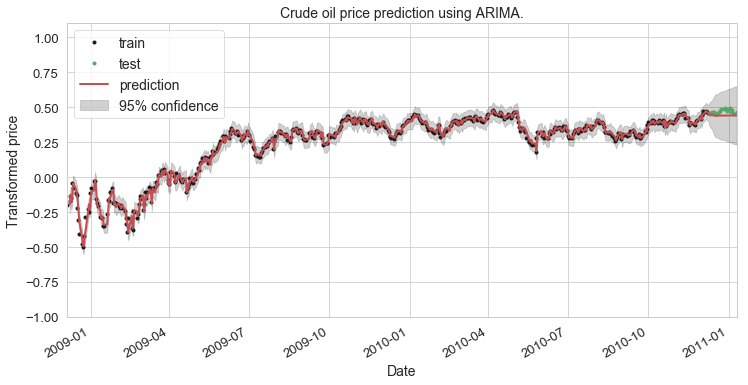

Done with slice number 10 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 20 out of 100.
Done with slice number 30 out of 100.
Done with slice number 40 out of 100.
Done with slice number 50 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 60 out of 100.
Done with slice number 70 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 80 out of 100.
Done with slice number 90 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 100 out of 100.


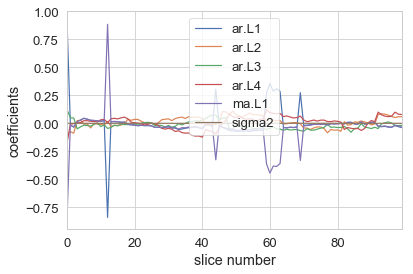

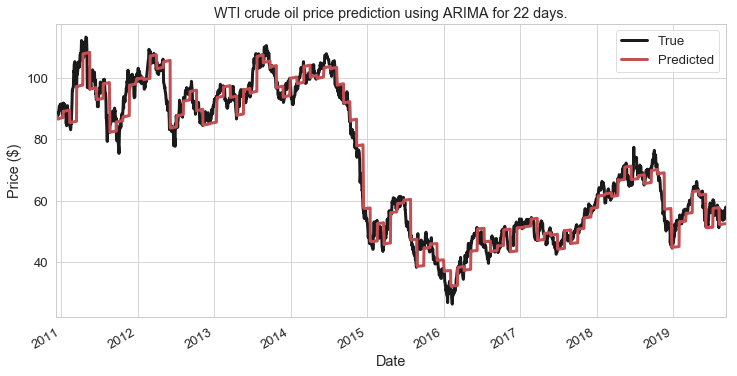

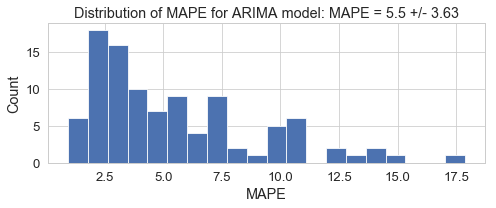

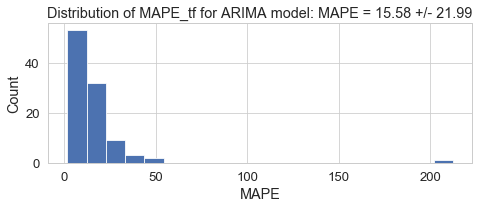

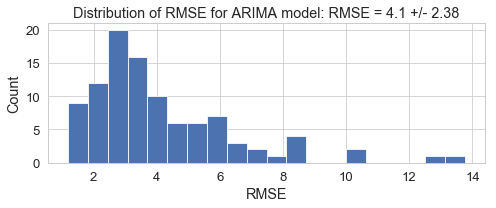

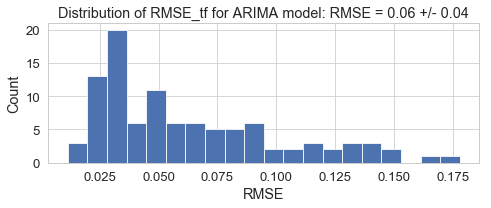

In [13]:
######################################################
##############CV and window optimization##############
######################################################
#Here two years of train data is used to predict 1 month ahead.

#number of CV slices
cv_num = 100
#253 trading days per year
n_inputs = 253 * 2
#22 B_days per month
n_outputs = 22

#select target: smooth or actual
target = 'y' #f'y_smooth_w{window}'
#add exogenous variable
add_exog = 0 #0 or 1 (boolean)
exog_col = '' #'MA_50_min_MA_200' #'MACC_50'

#choose folder name to save results
path = 'CV_arima'

#fit model and calculate metrics
df_metric, df_coeff, df_true_pred = cv_arima(df, cv_num, n_inputs, n_outputs, path, 
                               target, params = (4,1,1), model_name = 'ARIMA',
                               add_exog = 0)

Folder CV_arima already exists.
CV_arima/y_smooth_w8_train_506_test_22_cv_100
Use 506 points to predict 22.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


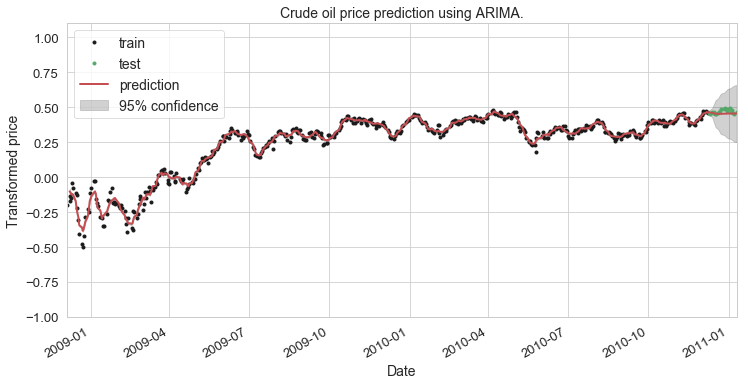

/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 10 out of 100.
Done with slice number 20 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 30 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 40 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 50 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 60 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 70 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 80 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 90 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/stat

Done with slice number 100 out of 100.


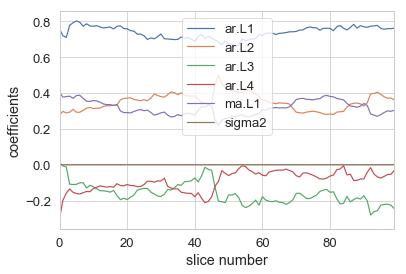

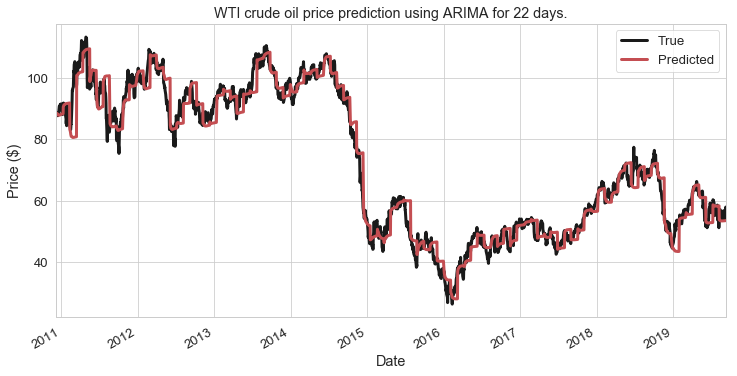

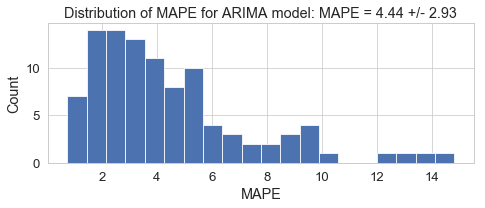

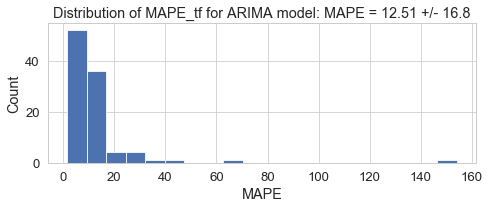

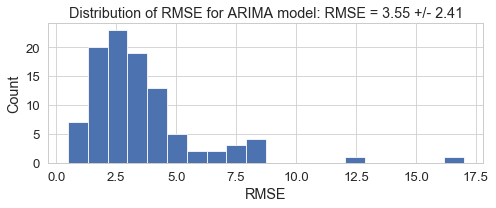

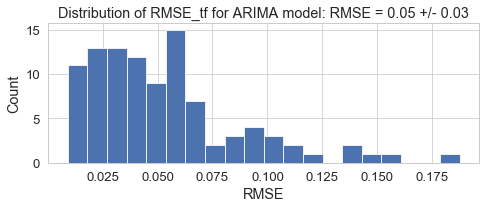

In [14]:
#calculate predictions for 22 days ahead and smooth target
n_outputs = 22
target = f'y_smooth_w{window}'

df_metric, df_coeff, df_true_pred = cv_arima(df, cv_num, n_inputs, n_outputs, path, 
                               target, params = (4,1,1), model_name = 'ARIMA',
                               add_exog = 0)

Folder CV_arima already exists.
CV_arima/y_smooth_w8_train_506_test_5_cv_100
Use 506 points to predict 5.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


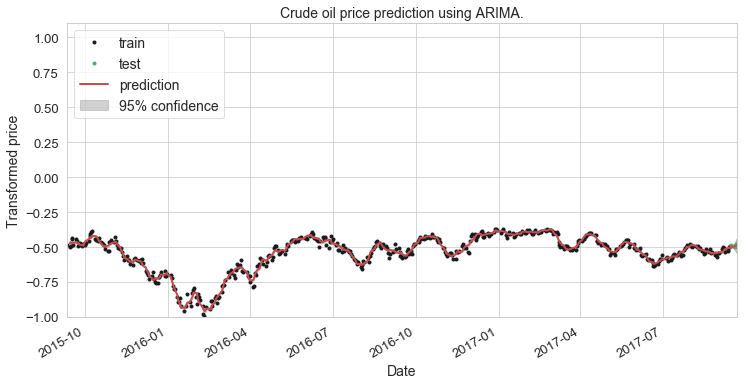

/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 10 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 20 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 30 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 40 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 50 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 60 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 70 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 80 out of 100.


/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Evgeniya/anaconda/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done with slice number 90 out of 100.
Done with slice number 100 out of 100.


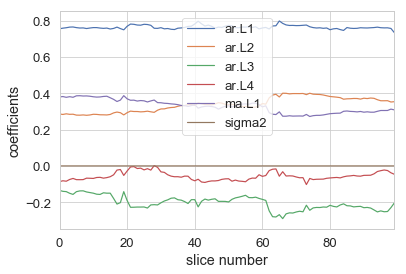

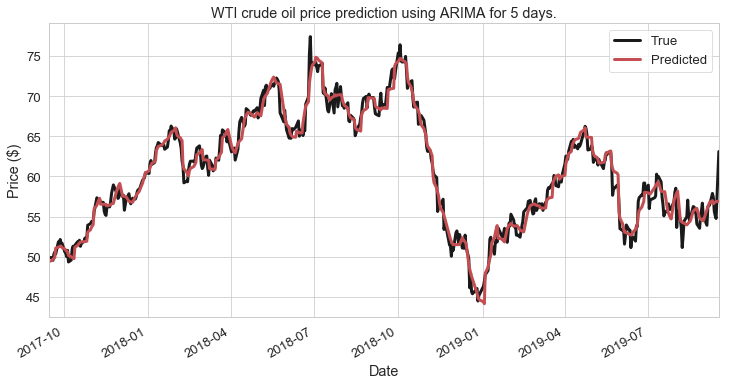

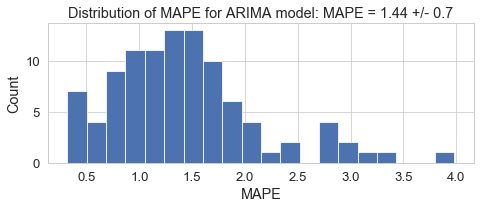

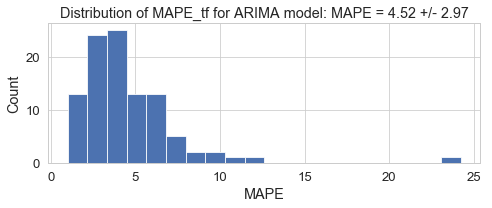

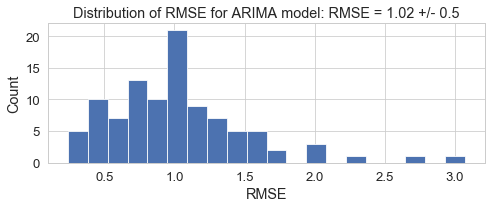

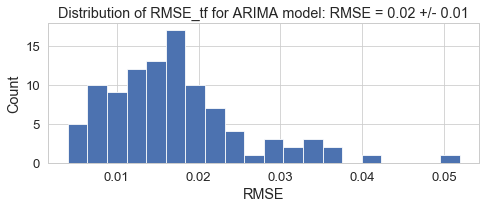

In [15]:
#calculate predictions for 5 days ahead and smooth target
n_outputs = 5

df_metric, df_coeff, df_true_pred = cv_arima(df, cv_num, n_inputs, n_outputs, path, 
                               target, params = (4,1,1), model_name = 'ARIMA',
                               add_exog = 0)